# RYAN FRANCO
# CS677
# USING DEEP LEARNING TO DETERMINE PNEUMONIA DIAGNOSIS ON CHEST X-RAYS

## TABLE OF CONTENTS:
* [I. IMPORTS AND LOADING DATASET](#Imports-and-Loading-Dataset)
* [II. COMPARISONS OF DATASET](#COMPARISONS)
* [III. PREPARING THE MODEL](#PREPARATION)
* [IV. CUSTOM MODEL](#CUSTOM-MODEL:-CNN)
* [V. BASELINE MODEL](#BASELINE-MODEL:-TRANSFER-LEARNING-WITH-VGG19)
* [VI. EVALUATIONS](#EVALUATING-THE-MODEL)


## Imports and Loading Dataset

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random
import os

from numpy.random import seed
seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

import glob
import cv2

In [2]:

main_path = "chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [3]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [4]:
df_train


,class,image
0,Normal,chest_xray\train/NORMAL\NORMAL-1003233-0001.jpeg
1,Normal,chest_xray\train/NORMAL\NORMAL-1012843-0001.jpeg
2,Normal,chest_xray\train/NORMAL\NORMAL-1014768-0001.jpeg
3,Normal,chest_xray\train/NORMAL\NORMAL-1023731-0001.jpeg
4,Normal,chest_xray\train/NORMAL\NORMAL-1029510-0001.jpeg
...,...,...
5227,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-9934736-0003....
5228,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-9947411-0002....
5229,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-9962961-0002....
5230,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-9963654-0001....


In [5]:
df_test

,class,image
0,Normal,chest_xray\test/NORMAL\NORMAL-1049278-0001.jpeg
1,Normal,chest_xray\test/NORMAL\NORMAL-1110860-0001.jpeg
2,Normal,chest_xray\test/NORMAL\NORMAL-11419-0001.jpeg
3,Normal,chest_xray\test/NORMAL\NORMAL-115218-0001.jpeg
4,Normal,chest_xray\test/NORMAL\NORMAL-1160949-0001.jpeg
...,...,...
619,Pneumonia,chest_xray\test/PNEUMONIA\VIRUS-9584831-0001.jpeg
620,Pneumonia,chest_xray\test/PNEUMONIA\VIRUS-9671740-0001.jpeg
621,Pneumonia,chest_xray\test/PNEUMONIA\VIRUS-9783315-0001.jpeg
622,Pneumonia,chest_xray\test/PNEUMONIA\VIRUS-9890836-0001.jpeg


In [54]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
df_train_x = df_train['image']
df_train_y = df_train['class']
df_test_x = df_test['image']
df_test_y =df_test['class'].copy().map(num_label).astype('int')

## COMPARISONS

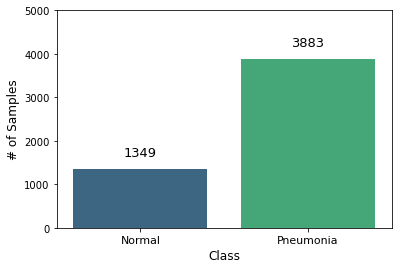

In [7]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="viridis")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

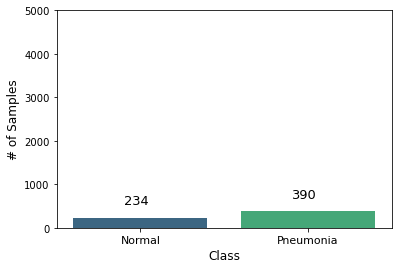

In [8]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="viridis")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

Train Set - Normal


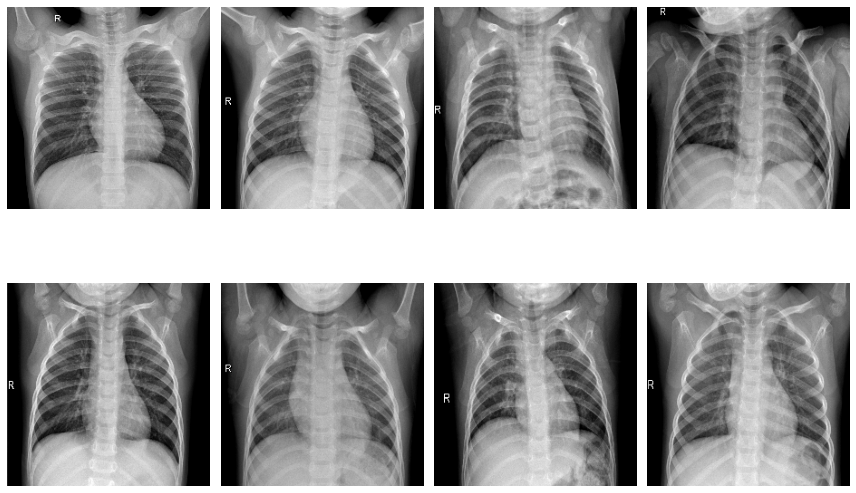

In [9]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 8):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


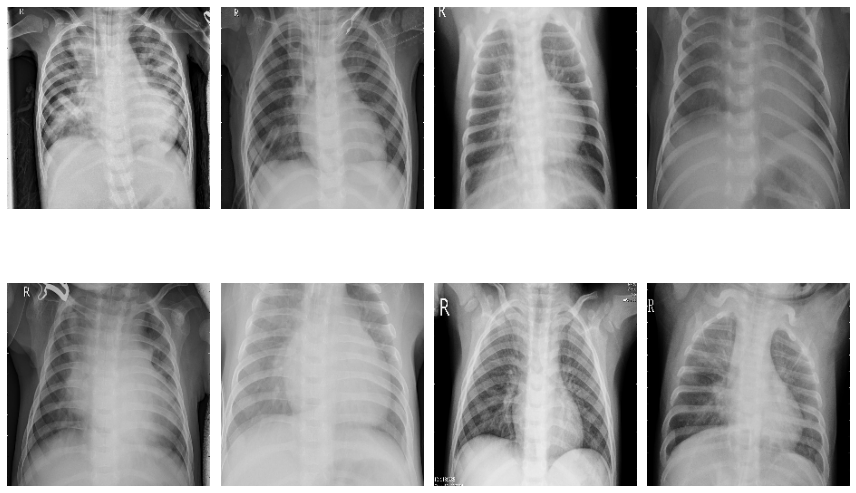

In [10]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 8):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

## PREPARATION

In [11]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 10, stratify = df_train_y)

In [12]:
train_df

,class,image
1102,Normal,chest_xray\train/NORMAL\NORMAL-8349062-0001.jpeg
4163,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-289775-0001.jpeg
1930,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-3170240-00...
1724,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-2410320-00...
149,Normal,chest_xray\train/NORMAL\NORMAL-2180796-0001.jpeg
...,...,...
1381,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-1083680-00...
2401,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-4719778-00...
3664,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-9120067-00...
2638,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-5476259-00...


In [13]:
val_df

,class,image
283,Normal,chest_xray\train/NORMAL\NORMAL-293382-0001.jpeg
1098,Normal,chest_xray\train/NORMAL\NORMAL-8339410-0001.jpeg
2911,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-6461260-00...
1807,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-2696292-00...
472,Normal,chest_xray\train/NORMAL\NORMAL-4122298-0001.jpeg
...,...,...
4817,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-7132765-0002....
4834,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-7245232-0001....
3680,Pneumonia,chest_xray\train/PNEUMONIA\BACTERIA-9176919-00...
4230,Pneumonia,chest_xray\train/PNEUMONIA\VIRUS-3448615-0001....


In [40]:
train_datagen = ImageDataGenerator(rescale=1/223.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/223.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',  batch_size = 32,
                                             seed = 10)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 32,
                                            seed = 10)
ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (224, 224),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## CUSTOM MODEL: CNN

In [15]:
tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = (3, 3),
    strides=(1, 1),
    padding="same",
    activation="relu")

tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
)

In [16]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(filters = 32, 
                                     kernel_size = (3, 3), 
                                     activation='relu',
                                     input_shape=(224, 224, 3)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(tf.keras.layers.Conv2D(filters = 32, 
                                     kernel_size = (3, 3), 
                                     activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
              
# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['binary_accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5972032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [17]:
cnn_model.fit(ds_train, epochs=10, batch_size = 32, steps_per_epoch = len(train_df)//32,
validation_steps = len(val_df)//32)


Epoch 1/10
130/130 [==============================] - 104s 799ms/step - loss: 0.4241 - binary_accuracy: 0.8218
Epoch 2/10
130/130 [==============================] - 102s 782ms/step - loss: 0.2290 - binary_accuracy: 0.9061
Epoch 3/10
130/130 [==============================] - 103s 790ms/step - loss: 0.2167 - binary_accuracy: 0.9157
Epoch 4/10
130/130 [==============================] - 103s 794ms/step - loss: 0.1959 - binary_accuracy: 0.9249
Epoch 5/10
130/130 [==============================] - 102s 781ms/step - loss: 0.2036 - binary_accuracy: 0.9181
Epoch 6/10
130/130 [==============================] - 104s 798ms/step - loss: 0.1904 - binary_accuracy: 0.9251
Epoch 7/10
130/130 [==============================] - 103s 789ms/step - loss: 0.1887 - binary_accuracy: 0.9275
Epoch 8/10
130/130 [==============================] - 103s 789ms/step - loss: 0.1759 - binary_accuracy: 0.9316
Epoch 9/10
130/130 [==============================] - 104s 802ms/step - loss: 0.1594 - binary_accuracy: 0.9408
E

In [18]:
score = cnn_model.evaluate(ds_val, steps = len(val_df)/32, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.11556600779294968
Val accuracy: 0.9541547298431396


## BASELINE MODEL: TRANSFER LEARNING WITH VGG19

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19

In [20]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))
x = model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x= Dense(1,activation='sigmoid')(x)

In [21]:
model = Model(inputs=model.input, outputs=x)

In [22]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy']) 
history = model.fit(ds_train, validation_data=ds_val, epochs=10, batch_size=32)

Epoch 1/10
131/131 [==============================] - 1596s 12s/step - loss: 0.8843 - binary_accuracy: 0.7283 - val_loss: 0.5714 - val_binary_accuracy: 0.7421
Epoch 2/10
131/131 [==============================] - 1600s 12s/step - loss: 0.5718 - binary_accuracy: 0.7431 - val_loss: 0.5759 - val_binary_accuracy: 0.7421
Epoch 3/10
131/131 [==============================] - 1628s 12s/step - loss: 0.7700 - binary_accuracy: 0.7281 - val_loss: 0.6180 - val_binary_accuracy: 0.7421
Epoch 4/10
131/131 [==============================] - 1565s 12s/step - loss: 0.5820 - binary_accuracy: 0.7379 - val_loss: 0.5708 - val_binary_accuracy: 0.7421
Epoch 5/10
131/131 [==============================] - 1532s 12s/step - loss: 0.5721 - binary_accuracy: 0.7422 - val_loss: 0.5730 - val_binary_accuracy: 0.7421
Epoch 6/10
131/131 [==============================] - 1813s 14s/step - loss: 0.5523 - binary_accuracy: 0.7424 - val_loss: 0.3038 - val_binary_accuracy: 0.7421
Epoch 7/10
131/131 [==========================

## EVALUATING THE MODEL

In [48]:
ds_test.reset()
test = cnn_model.predict(ds_test)

In [50]:
pred_labels= np.where(test>0.5, 1, 0)
print(pred_labels)

[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]


In [56]:
print("Test Accuracy: ", accuracy_score(df_test_y, pred_labels))

Test Accuracy:  0.8253205128205128


In [57]:
vggtest = model.predict(ds_test)

In [58]:
vggpred_labels= np.where(vggtest>0.5, 1, 0)


In [59]:
print("Test Accuracy: ", accuracy_score(df_test_y, vggpred_labels))

Test Accuracy:  0.8108974358974359


In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(df_test_y, pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.55      0.70       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



In [62]:
print(classification_report(df_test_y, vggpred_labels))

              precision    recall  f1-score   support

           0       0.96      0.52      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624



In [69]:
from sklearn.metrics import roc_auc_score

In [70]:
print(roc_auc_score(df_test_y, pred_labels))

0.7705128205128206


In [71]:
print(roc_auc_score(df_test_y, vggpred_labels))

0.7521367521367521
